# Homework 2


In [1]:
import pandas as pd
import numpy as np
from fredapi import Fred
fred = Fred(api_key="7a9c02dcad776de16efb3eef1a2b293d")
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from scipy import stats
%matplotlib inline

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble, tree, linear_model

## Data Cleaning and Visualization

### Getting data from the CSV files.

In [2]:
train = pd.read_csv("C:\Stuff\AFO_Sightings.csv", low_memory=False)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test = pd.read_csv("C:\Stuff\other_data.csv", low_memory=False)
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
train_shape = train.shape[0]
test_shape = test.shape[0]
test.Id = test['Id']

In [5]:
data = pd.concat((train, test)).reset_index(drop = True)

### Looking for missing data in both training and testing data.
I did this by combining both training and testing data and then creating a function that will go through and return the number of missing datapoints in each column. 

In [6]:
def missing_data():
    NA = train.columns[train.isnull().any()].tolist()
    return NA

train[missing_data()].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

### Alley
After looking at the data, it seems that whenever an Alley has an NA, it means that there is no alley access. Therefore I chose to replace all missing values with 'None'

In [7]:
train.loc[train['Alley'].isnull(),'Alley'] = 'None'
test.loc[test['Alley'].isnull(),'Alley'] = 'None'

### LotFrontage
I had a harder time figuring out what I should do with LotFrontage. Obviously these values shoulding be zero. So I decided to take the mean of all the values I did have and then insert those at missing variables. 

In [8]:
train['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [9]:
train.loc[train['LotFrontage'].isnull(),'LotFrontage'] = 70.049958
test.loc[test['LotFrontage'].isnull(),'LotFrontage'] = 70.049958

### Functional
According to the data description, the missing values in this should be Typ

In [10]:
train.loc[train['Functional'].isnull(),'Functional'] = 'Typ'
test.loc[test['Functional'].isnull(),'Functional'] = 'Typ'

### MasVnrType and MasVnrArea
It looks like the missing values for these to are in the exact same rows. I then looked and found that the most common MasVnrType is None. I thus decided to change all missing values in Area to 0 and in Type to None. 

In [11]:
train[['MasVnrType','MasVnrArea']][train['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [12]:
train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [13]:
train.loc[train['MasVnrType'].isnull(),'MasVnrType'] = 'None'
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
test["MasVnrType"] = test["MasVnrType"].fillna('None')
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

### Basements
After looking at the data, I figured that those with missing basement features meant that these homes did not include a basement as there are the same number of missing values for each feature. Thus, I changed each missing value to None if it was categorical and 0 if it was numerical. 

In [14]:
train.loc[train['BsmtQual'].isnull(),'BsmtQual'] = 'None'
train.loc[train['BsmtCond'].isnull(),'BsmtCond'] = 'None'
train.loc[train['BsmtExposure'].isnull(),'BsmtExposure'] = 'None'
train.loc[train['BsmtFinType1'].isnull(),'BsmtFinType1'] = 'None'
train.loc[train['BsmtFinType2'].isnull(),'BsmtFinType2'] = 'None'
train.loc[train['BsmtFinSF1'].isnull(),'BsmtFinSF1'] = 0
train.loc[train['BsmtFinSF2'].isnull(),'BsmtFinSF2'] = 0
train.loc[train['BsmtUnfSF'].isnull(),'BsmtUnfSF'] = 0    
train.loc[train['TotalBsmtSF'].isnull(),'TotalBsmtSF'] = 0
train.loc[train['BsmtFullBath'].isnull(),'BsmtFullBath'] = 0
train.loc[train['BsmtHalfBath'].isnull(),'BsmtHalfBath'] = 0


test.loc[test['BsmtQual'].isnull(),'BsmtQual'] = 'None'
test.loc[test['BsmtCond'].isnull(),'BsmtCond'] = 'None'
test.loc[test['BsmtExposure'].isnull(),'BsmtExposure'] = 'None'
test.loc[test['BsmtFinType1'].isnull(),'BsmtFinType1'] = 'None'
test.loc[test['BsmtFinType2'].isnull(),'BsmtFinType2'] = 'None'
test.loc[test['BsmtFinSF1'].isnull(),'BsmtFinSF1'] = 0
test.loc[test['BsmtFinSF2'].isnull(),'BsmtFinSF2'] = 0
test.loc[test['BsmtUnfSF'].isnull(),'BsmtUnfSF'] = 0
test.loc[test['TotalBsmtSF'].isnull(),'TotalBsmtSF'] = 0
test.loc[test['BsmtFullBath'].isnull(),'BsmtFullBath'] = 0
test.loc[test['BsmtHalfBath'].isnull(),'BsmtHalfBath'] = 0

### KitchenQual
The most common value is TA so we will set the one null value to this. 

In [15]:
train.loc[train['KitchenQual'].isnull(),'KitchenQual'] = 'TA'
test.loc[test['KitchenQual'].isnull(),'KitchenQual'] = 'TA'

In [16]:
train['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

### SaleType
Most common sale type is WD so I will fill the missing value with this. 

In [17]:
train['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [18]:
train.loc[train['SaleType'].isnull(),'SaleType'] = 'WD'
test.loc[test['SaleType'].isnull(),'SaleType'] = 'WD'

### Electrical
There is only one missing electrical value in the traing data, so I found that the most common type of Electrical is SBrkr and used that to replace the missing values. 

In [19]:
train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [20]:
train.loc[train['Electrical'].isnull(),'Electrical'] = 'SBrkr'
test.loc[test['Electrical'].isnull(),'Electrical'] = 'SBrkr'

### Fireplaces
This one was pretty easy. The data suggests that places with missing values simply indicates that there is no fireplace. Thus I replaced these values with None.

In [21]:
train.loc[train['FireplaceQu'].isnull(),'FireplaceQu'] = 'None'
test.loc[test['FireplaceQu'].isnull(),'FireplaceQu'] = 'None'

### Garages
There are 81 missing values for each garage characteristic so we can assume that these are all in the same 81 rows for houses that do not have a garage. I thus changed each of these to None if it was categorical and zero if it was numerical. For the year built however, I took the average. 

In [22]:
train['GarageYrBlt'].describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [23]:
train.loc[train['GarageArea'].isnull(),'GarageArea'] = 0
train.loc[train['GarageCars'].isnull(),'GarageCars'] = 0
train.loc[train['GarageCond'].isnull(),'GarageCond'] = 'None'
train.loc[train['GarageQual'].isnull(),'GarageQual'] = 'None'
train.loc[train['GarageType'].isnull(),'GarageType'] = 'None'
train.loc[train['GarageYrBlt'].isnull(),'GarageYrBlt'] = 1978.506164
train.loc[train['GarageFinish'].isnull(),'GarageFinish'] = 'None'

test.loc[test['GarageArea'].isnull(),'GarageArea'] = 0
test.loc[test['GarageCars'].isnull(),'GarageCars'] = 0
test.loc[test['GarageCond'].isnull(),'GarageCond'] = 'None'
test.loc[test['GarageQual'].isnull(),'GarageQual'] = 'None'
test.loc[test['GarageType'].isnull(),'GarageType'] = 'None'
test.loc[test['GarageYrBlt'].isnull(),'GarageYrBlt'] = 1978.506164
test.loc[test['GarageFinish'].isnull(),'GarageFinish'] = 'None'

### Pool
For pools, I replaced the missing values to None as it's likely that this simply indicates that people don't have a pool after looking at the data.

In [24]:
train.loc[train['PoolQC'].isnull(),'PoolQC'] = 'None'
test.loc[test['PoolQC'].isnull(),'PoolQC'] = 'None'

### Fence
For the missing values in fence, I changed these to None because it's likely that this indicates no fence on the property.

In [25]:
train.loc[train['Fence'].isnull(),'Fence'] = 'None'
test.loc[test['Fence'].isnull(),'Fence'] = 'None'

### MSZoning
These we will replace with RL as that is the most common.

In [26]:
train.loc[train['MSZoning'].isnull(),'MSZoning'] = 'RL'
test.loc[test['MSZoning'].isnull(),'MSZoning'] = 'RL'

### Utilities
Nearly all Utilities but one is AllPub so I will use that to replace the two missing values

In [27]:
train.loc[train['Utilities'].isnull(),'Utilities'] = 'AllPub'
test.loc[test['Utilities'].isnull(),'Utilities'] = 'AllPub'

### Exteriors
I will replace the missing exterior values with the most common value.


In [28]:
train['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
CBlock       1
ImStucc      1
AsphShn      1
Name: Exterior1st, dtype: int64

In [29]:
train['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

In [30]:
train.loc[train['Exterior1st'].isnull(),'Exterior1st'] = 'VinylSd'
test.loc[test['Exterior1st'].isnull(),'Exterior1st'] = 'VinylSd'

train.loc[train['Exterior2nd'].isnull(),'Exterior2nd'] = 'VinylSd'
test.loc[test['Exterior2nd'].isnull(),'Exterior2nd'] = 'VinylSd'

### MiscFeature
For these I just replaced the missing value to None. After looking at the data, I assume that the missing values indicatet that there is no other features to list.

In [31]:
train.loc[train['MiscFeature'].isnull(),'MiscFeature'] = 'None'
test.loc[test['MiscFeature'].isnull(),'MiscFeature'] = 'None'

In [32]:
train[missing_data()].isnull().sum()

Series([], dtype: float64)

In [33]:
test[missing_data()].isnull().sum()

Series([], dtype: float64)

In [34]:
train['MoSold'] = train['MoSold'].astype(str)
train['MSSubClass'] = train['MSSubClass'].astype(str)

test['MoSold'] = test['MoSold'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

### Data Visualization
First, I want to see a little more information about the variable I am predicting whcih is sale price. So I pulled up the descriptive statistics and additionally created a histogram. 

Then I created a heatmap of to see the correlation between different variables and especially sale price. It looks like the time sold, porch information, and pools have little corelation to sale price. However overall quality and garage characteristics seem to be positively correlated to sale price. I looked a little bit more at these specific variables by creating a scatter plot comparing each to sale price.

In [35]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

From this we can see that the minimum sale price is 34,900 while the maximum is 755,000. The mean for the training data is about 180,900.

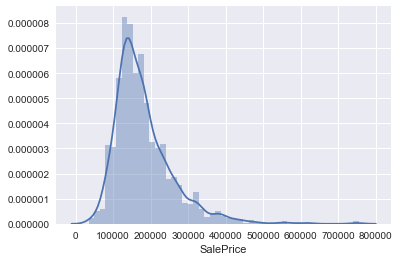

In [36]:
sns.distplot(train['SalePrice'])

Looks like the data is a bit skewed towards the right. 

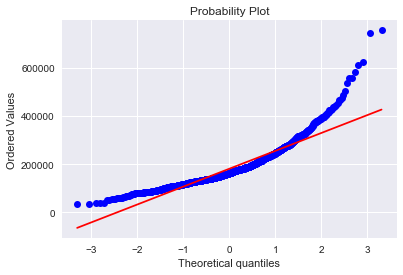

In [37]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

As seen above, the data for saleprice is rightly skewed. I wasn't sure how to fix this problem, but after looking at some other Kernals, I found that the best way to transform this would by through a log-transformation to get a normally distributed target variable. 

In [38]:
train["SalePrice"] = np.log1p(train["SalePrice"])

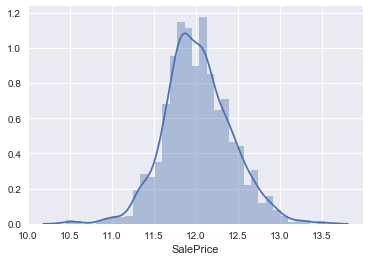

In [39]:
sns.distplot(train['SalePrice'])

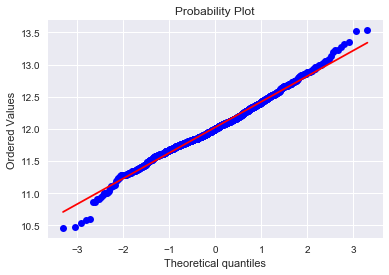

In [40]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Looks good! Now I'll take a look at the heatmap:

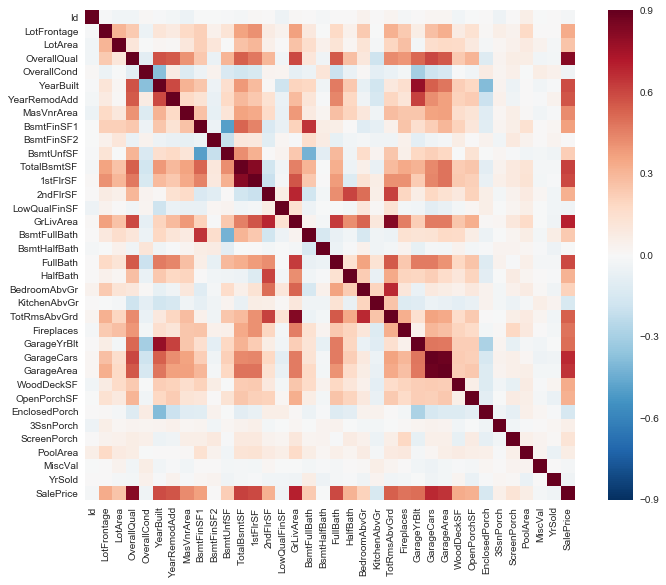

In [41]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

Scatterplots of most and least correated:

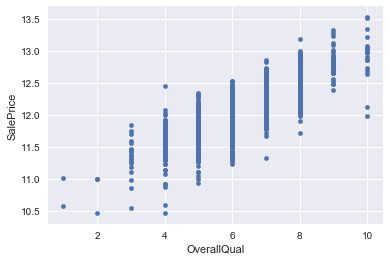

In [42]:
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

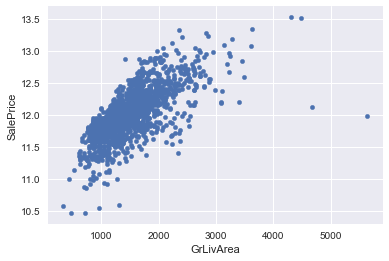

In [43]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

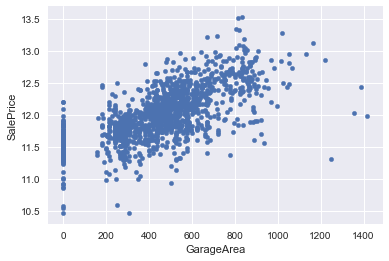

In [44]:
var = 'GarageArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

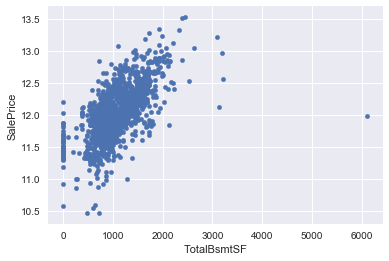

In [45]:
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

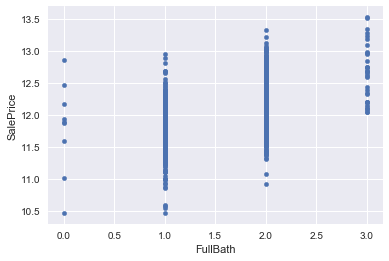

In [46]:
var = 'FullBath'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

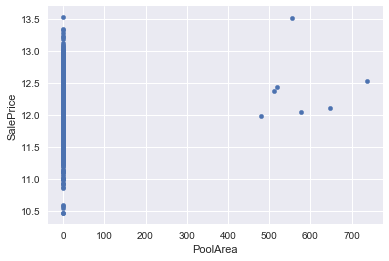

In [47]:
var = 'PoolArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

From the above scatter plots, we can see a strong positive relationship between overall quality and GrLivArea. The number of full baths additionally has a strong positive relationship. Pools which aren't supposed to have much of a correlation show this in their scatter plot but this could largely be due to the fact that the vast majority of houses don't have pools. TotalBsmtSF and GarageArea both have some sort of positive linear relationships with sale price. 

## Building the Models

### A little more cleanup
I needed to cahnge some of the variables to dummy variables. This caused a bit of a problem because some of the variables in the train data wasn't present in the test data. I fixed this by dropping those variables because they won't be helpful with predicting our model anyway. 

In [48]:
train = pd.get_dummies(train)

In [49]:
test = pd.get_dummies(test)

In [50]:
train.columns.difference(test.columns)

Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'GarageQual_Ex', 'Heating_Floor', 'Heating_OthW',
       'HouseStyle_2.5Fin', 'MiscFeature_TenC', 'PoolQC_Fa',
       'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'SalePrice', 'Utilities_NoSeWa'],
      dtype='object')

In [51]:
target= train.SalePrice
test_df = test.drop(['Id'], axis=1)

In [52]:
train_df = train.drop(['SalePrice'], axis = 1)
train_df = train_df.drop(['Id'], axis = 1)

In [53]:
missing_train = train_df.columns.difference(test_df.columns)

In [54]:
train_df = train_df.drop(missing_train, axis=1)

In [55]:
missing_test = test_df.columns.difference(train_df.columns)

In [56]:
test_df = test_df.drop(missing_test, axis=1)

### Scaling the Data:

In [57]:
numerical = list(train_df.select_dtypes(exclude=['object']))
len(numerical)

scaler = StandardScaler()
scaler.fit(train_df[numerical])
train_df[numerical] = scaler.transform(train_df[numerical])
train_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
2,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
3,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,...,-0.058621,-0.301962,-0.045376,0.390293,3.668167,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995
4,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [58]:
numerical = list(test_df.select_dtypes(exclude=['object']))
len(numerical)

test_df[numerical] = scaler.transform(test_df[numerical])
test_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.451936,0.110763,-0.795151,0.381743,-0.340077,-1.156380,-0.570750,0.053428,0.604293,-0.672923,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1,0.497357,0.375850,-0.071836,0.381743,-0.439440,-1.301740,0.027027,1.051363,-0.288653,-0.365032,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
2,0.179413,0.332053,-0.795151,-0.517200,0.852269,0.636400,-0.570750,0.761852,-0.288653,-0.974021,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
3,0.361095,-0.054002,-0.071836,0.381743,0.885390,0.636400,-0.460051,0.347326,-0.288653,-0.550672,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
4,-1.228623,-0.552407,1.374795,-0.517200,0.686666,0.345679,-0.570750,-0.396190,-0.288653,1.018211,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


### Splitting the Data

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, train['SalePrice'], test_size=0.33, random_state=42)

### My Models
I decided to try three different models for this. Elastic Net, Lasso, and Gradient Booster. Gradient Booster had a much higher accuracy so I went with that. 

In [60]:
ElasticNet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, max_iter=10000).fit(X_train, y_train))

In [61]:
score = cross_val_score(ElasticNet, train_df, target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.85 (+/- 0.11)


In [62]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [63]:
score = cross_val_score(lasso, train_df, target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.85 (+/- 0.10)


In [75]:
GB = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [76]:
score = cross_val_score(GB, train_df, target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.91 (+/- 0.03)


In [77]:
Elastic_model = ElasticNet.fit(train_df, target)

In [78]:
GB_model = GB.fit(train_df, target)

In [81]:
Final = np.exp(GB_model.predict(test_df))

pd.DataFrame({'ID': test.Id, 'SalePrice': Final}).to_csv('PleaseWork3.csv', index=False)